Import price data to train and test on

In [ ]:
import pandas as pd
import numpy as np

df_prices = pd.read_excel('Price.xlsx')
df_prices = df_prices.loc[df_prices['PriceArea'] == 'DK1']
df_prices.index = pd.to_datetime(df_prices['HourDK'])
df_prices = df_prices["PriceDKK"]
print("Total number of observations: ", len(df_prices))

Total number of observations:  23783


Plot prices to get an idea of how the price develops

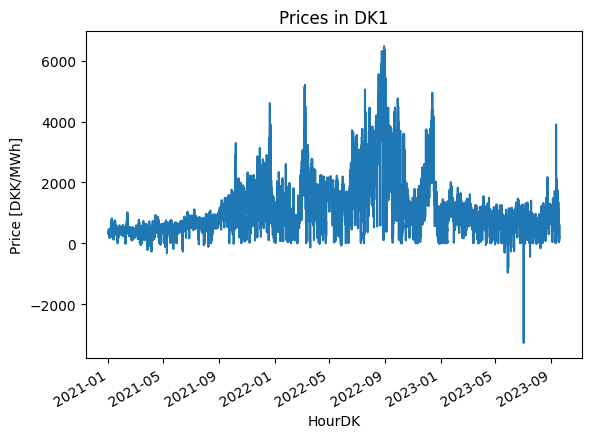

In [ ]:
df_prices.plot(title = "Prices in DK1", ylabel = "Price [DKK/MWh]")

Define actions and states, and allowed actions in different states. Only depends on SOC

In [ ]:
# Extract prices for 2023 as these appear to be stationary
prices = df_prices[df_prices.index.year == 2023].values

ACTIONS = ["Charge", "Discharge", "Do nothing"]
PRICE_STATE = ["Lowest", "Lower", "Medium", "Higher", "Highest"]
SOC_STATE = ["20%", "40%", "60%", "80%", "100%"]
ALLOWED_ACTIONS = {"20%":  ["Charge",              "Do nothing"], 
                   "40%":  ["Charge", "Discharge", "Do nothing"],
                   "60%":  ["Charge", "Discharge", "Do nothing"],
                   "80%":  ["Charge", "Discharge", "Do nothing"],
                   "100%": [          "Discharge", "Do nothing"],}

# Initialize the lookup-table
P_ssa_array = np.empty((len(PRICE_STATE), len(SOC_STATE), len(ACTIONS)), dtype=object)

Discretize, prepare, and estimate probability of transitioning from one price state to another. Also compute representative prices for each state

In [ ]:
def price_state(prices):
    # Split prices into discrete states
    percentiles = np.percentile(prices, np.linspace(0, 100, len(PRICE_STATE) + 1))
    price_states = np.array([(percentiles[i] <= prices) & (prices < percentiles[i+1]) for i in range(len(PRICE_STATE))], dtype=int)
    
    # Compute probability of being in a price state given the current price state.
    # Assumed independent of SOC state and action
    # price_prop = P(s'|s) -> price_prop[i,j] = P(s'=j|s=i)
    price_prop = (price_states @ np.roll(price_states,-1).T) / (price_states).sum(axis=1)

    # Generate representative prices
    price_representative = np.array([prices[price_states[i] == 1].mean() for i in range(len(PRICE_STATE))])

    return price_prop, price_representative, percentiles

Compute the transitioning matrix for each given state (price and SOC) and action. Limit allowed actions

In [ ]:
def P_ssa(price_prop, P_ssa_array):
    for i, ps in enumerate(PRICE_STATE):
        for j, ss in enumerate(SOC_STATE):
            for k, ac in enumerate(ACTIONS):
                # Given that we are in state ps, ss and take action ac
                # what is the probability of transitioning to each state (ps', ss')
                # i.e. P(s'=(ps', ss')| s=(ps, ss), ac)
                if ac in ALLOWED_ACTIONS[ss]:
                    if ac == "Charge":
                        c = 1
                    elif ac == "Discharge":
                        c = -1
                    else:
                        c = 0
                    SOC_prop = np.zeros((len(SOC_STATE)))
                    # if 0 <= j + c < len(SOC_STATE):  # Boundary check
                    SOC_prop[j + c] = 1 # SOC state is deterministic given action

                    # state_trans = P(price'|price) * P(soc'|soc, action)
                    state_trans = price_prop[i, :].reshape(-1, 1) @ SOC_prop.reshape(1, -1)
                    P_ssa_array[i, j, k] = state_trans  # Assign to the correct variable
                else: # Impossible action, set P to zero
                    P_ssa_array[i, j, k] = np.zeros((len(PRICE_STATE), len(SOC_STATE)))

    return P_ssa_array


Generate reward function. The reward is the expected revenue from the action, defined using representative prices for each price state and a fixed power

In [68]:
def rewards(price_state, action, price_representative):
    # Reward based on revenue from charging/discharging
    if action == "Charge":
        reward = - 100 * price_representative[PRICE_STATE.index(price_state)]
    elif action == "Discharge":
        reward = 100 * price_representative[PRICE_STATE.index(price_state)]
    else:
        reward = 0
    return reward

In [88]:
def value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representatives, P_ssa, gamma=0.9, epsilon=1e-6):
    """
    Perform value iteration for a 2D state space with given parameters.

    Parameters:
    - PRICE_STATE: List of discrete price states
    - SOC_STATE: List of discrete state of charge (SOC) states
    - ALLOWED_ACTIONS: A dictionary mapping each SOC state to a list of valid actions
    - rewards: A function `rewards(price_state, action)` that returns the immediate reward
    - P_ssa: Transition probability matrix
    - gamma: Discount factor (default 0.9)
    - epsilon: Convergence threshold (default 1e-6)

    Returns:
    - V: Optimal value function
    - policy: Optimal policy for each state
    """
    # Initialize the value function to 0 for all states
    V = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
    policy = np.zeros((len(PRICE_STATE), len(SOC_STATE)), dtype=object)
    V_list = []
    V_list.append(V)
    V_new_list = []
    count = 0
    while True:
        # Initialize the new value function
        V_new = np.zeros((len(PRICE_STATE), len(SOC_STATE)))
        V_new_list.append(V_new)
        
        for i, ps in enumerate(PRICE_STATE):  # Iterate over price states
            for j, ss in enumerate(SOC_STATE):  # Iterate over SOC states
                # # Get the valid actions for the current SOC state
                valid_actions = ALLOWED_ACTIONS[ss]

                # Compute the action values for each action
                action_value = [rewards(ps, ac, price_representatives) + gamma * np.trace(P_ssa[i,j,k] @ V.T)
                                      for k, ac in enumerate(ACTIONS) if ac in valid_actions]

                # Update the value function with the max action value
                V_new[i,j] = np.max(action_value)
                
                # Store the optimal action index
                policy[i, j] = valid_actions[np.argmax(action_value)]

        # Check for convergence
        count += 1
        if np.max(np.abs(V - V_new)) < epsilon:
            # print(f"Converged after {count} iterations")
            break

        # Update the value function
        V = V_new

    return V, policy, count, V_list, V_new_list

Split into training and testing

In [89]:
# Split the data into training, validation and test sets, with 80% training, of which 80% is used for training and 20% for validation  
N = len(prices)

train_test_fraction = 0.8
train_val_fraction = 0.8
train_test_split = int(np.floor(N * train_test_fraction))
train_val_split = int(np.floor(train_test_split * train_val_fraction))

x_train = prices[:train_test_split]
x_train_train = x_train[:train_val_split]
x_val = x_train[train_val_split:]
x_test = prices[train_test_split:]


len(x_train), len(x_test)

(5010, 1253)

We can now define a function for simulating the actual operation of the battery based on a given policy

In [ ]:
def simulate_policy_with_boundaries(real_prices, policy, percentiles_train, PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20):
    """
    Simulate hourly operation of a battery using a policy matrix and price state boundaries.

    Parameters:
    - real_prices: List of hourly price data.
    - policy: Policy matrix 
    - percentiles_train: The percentiles defining the price states (for digitizing the real prices).
    - PRICE_STATE: List of price state labels.
    - SOC_STATE: List of discrete SOC levels (percentage).
    - max_soc_percent: Maximum state of charge (percentage).
    - soc_step_percent: SOC increment in percentage (20% = 100 MW).

    Returns:
    - total_cost: Total cumulative cost/revenue from simulation.
    - hourly_profits: A list of profits/revenues for each hour.
    """
    # Initialize variables
    soc_percentage = 0  # Starting state of charge in percentage (0% means 0 MWh capacity)
    hourly_revenue = []  # List to store the profit for each hour

    # Map SOC_STATE to percentage levels (["20%", "40%", "60%", "80%", "100%"])
    soc_levels_percentage = np.array([int(s.strip('%')) for s in SOC_STATE])  # Convert SOC to percentage

    # Determine price state (index in PRICE_STATE)
    price_quantiles = np.digitize(real_prices, percentiles_train) - 1
    price_quantiles[price_quantiles < 0] = 0  # Assign values lower than the lowest percentile to the lowest bin
    price_quantiles[price_quantiles >= len(PRICE_STATE)] = len(PRICE_STATE) - 1  # Assign values higher than the highest percentile to the highest bin

    # Simulate hourly operation
    for hour, price in enumerate(real_prices):
        
        # Determine the price state for the current hour
        price_state_index = price_quantiles[hour]
        # price_state_label = PRICE_STATE[price_state_index]

        # Determine SOC state (index in SOC_STATE)
        soc_index = np.argmin(np.abs(soc_levels_percentage - soc_percentage))  # Find closest match to the current SOC percentage

        # Retrieve the action from the policy matrix (Charge, Discharge, Do nothing)
        action = policy[price_state_index, soc_index]

        # Calculate the revenue based on the action
        if action == "Charge":
            revenue = -100 * price  # Charging cost
        elif action == "Discharge":
            revenue = 100 * price
        else:
            revenue = 0
        hourly_revenue.append(revenue)  # Store profit for this hour


        # Update SOC based on the action (in percentage terms)
        if action == "Charge":
            # Increase SOC by 20% (100 MW = 100 MWh)
            soc_percentage = min(soc_percentage + soc_step_percent, max_soc_percent)  # Ensure SOC doesn't exceed 100%
        elif action == "Discharge":
            # Decrease SOC by 20% (100 MW = 100 MWh)
            soc_percentage = max(soc_percentage - soc_step_percent, 0)  # Ensure SOC doesn't go below 0%
        elif action == "Do nothing":
            # SOC remains the same (Do nothing)
            pass

        # Print the profit for this hour, updated SOC percentage, and the corresponding price state
        # print(f"Hour {hour+1}, Price: {np.round(price)}, Price State: {price_state_label}, Action: {action}, Revenue: {np.round(revenue)}, SOC: {soc_percentage}%")

    # Calculate total revenue and return hourly revenue
    total_revenue = sum(hourly_revenue)  
    return total_revenue, hourly_revenue  


The operation of the battery and its revenue can be determined for different gammas to find the optimal in the validation set

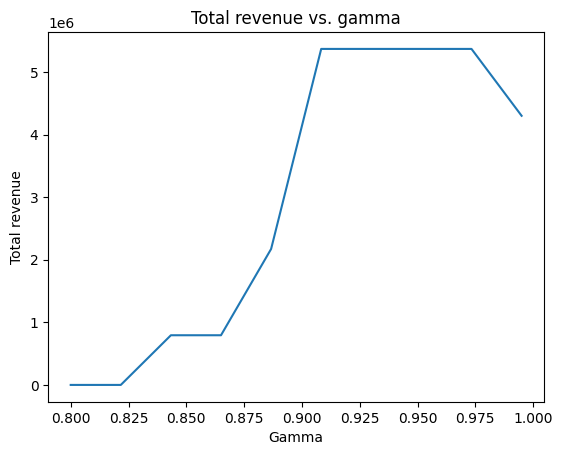

In [91]:
import matplotlib.pyplot as plt
price_prop, price_representative, percentiles = price_state(x_train_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)

gammas = np.linspace(0.8, 0.995, 10)
revenues = []
for gamma in gammas:
    V_train, policy_train, _, _, _ = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=gamma, epsilon=1e-6)
    total_revenue_val, hourly_revenue_val = simulate_policy_with_boundaries(x_val, policy_train, percentiles, PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)
    revenues.append(total_revenue_val)

opt_gamma = gammas[np.argmax(revenues)] # Find the gamma that maximizes revenue

# Plot the total revenue as a function of gamma
plt.plot(gammas, revenues)
plt.xlabel("Gamma")
plt.ylabel("Total revenue")
plt.title("Total revenue vs. gamma")
plt.show()

Comparing test profits with profits yielded if MDP was run on test data

In [97]:
price_prop, price_representative, percentiles = price_state(x_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)
V_train, policy_train, _, _, _ = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma, epsilon=1e-6)
total_revenue_test, hourly_revenue_test1 = simulate_policy_with_boundaries(x_test, policy_train, percentiles, PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

print(total_revenue_test/1E6)
policy_train

4.0852890128000015


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

In [100]:
price_prop, price_representative, percentiles = price_state(x_train)
P_ssa_est = P_ssa(price_prop, P_ssa_array)
V_train, policy_train, _, _, _ = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative, P_ssa_est, gamma=opt_gamma, epsilon=1e-6)
total_revenue_test, hourly_revenue_test2 = simulate_policy_with_boundaries(x_test, policy_train, percentiles, PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

print(total_revenue_test/1E6)
policy_train

4.0852890128000015


array([['Charge', 'Charge', 'Charge', 'Charge', 'Do nothing'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge'],
       ['Do nothing', 'Discharge', 'Discharge', 'Discharge', 'Discharge']],
      dtype=object)

In [203]:
total_cost_test_test, hourly_profits_test_test = simulate_policy_with_boundaries(test, policy_test_p, percentiles_test,PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

Hour 1, Price: 781.590027, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 0%
Hour 2, Price: 605.72998, Price State: Medium, Action: Charge, Profit: -49082.39928, SOC: 20%
Hour 3, Price: 0.22, Price State: Lowest, Action: Charge, Profit: 27527.9999, SOC: 40%
Hour 4, Price: 125.849998, Price State: Lowest, Action: Charge, Profit: 27527.9999, SOC: 60%
Hour 5, Price: 818.049988, Price State: Higher, Action: Discharge, Profit: 66444.80102, SOC: 40%
Hour 6, Price: 885.530029, Price State: Higher, Action: Discharge, Profit: 66444.80102, SOC: 20%
Hour 7, Price: 346.839996, Price State: Lower, Action: Charge, Profit: -34536.80114, SOC: 40%
Hour 8, Price: 825.159973, Price State: Higher, Action: Discharge, Profit: 66444.80102, SOC: 20%
Hour 9, Price: 520.960022, Price State: Medium, Action: Charge, Profit: -49082.39928, SOC: 40%
Hour 10, Price: 347.269989, Price State: Lower, Action: Charge, Profit: -34536.80114, SOC: 60%
Hour 11, Price: -24.459999, Price State: Lowest, Action: Charge,

In [204]:
price_prop_all, price_representative_all, percentiles_all = price_state(prices)
P_ssa_all = P_ssa(price_prop_all, P_ssa_array)
V_all_p, policy_all_p, count_all_p, V_list_all_p, V_new_list_all_p = value_policy_iteration(PRICE_STATE, SOC_STATE, ALLOWED_ACTIONS, price_representative_all, P_ssa_all, gamma=0.9, epsilon=1e-6)

print(policy_all_p)



Converged after 162 iterations
[['Charge' 'Do nothing' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']
 ['Do nothing' 'Discharge' 'Discharge' 'Discharge' 'Discharge']]


In [205]:
total_cost_all, hourly_profits_all = simulate_policy_with_boundaries(test, policy_all_p, percentiles_all,PRICE_STATE, SOC_STATE, max_soc_percent=100, soc_step_percent=20)

Hour 1, Price: 781.590027, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 0%
Hour 2, Price: 605.72998, Price State: Medium, Action: Do nothing, Profit: 0, SOC: 0%
Hour 3, Price: 0.22, Price State: Lowest, Action: Charge, Profit: 32651.001000000004, SOC: 20%
Hour 4, Price: 125.849998, Price State: Lowest, Action: Charge, Profit: 32651.001000000004, SOC: 40%
Hour 5, Price: 818.049988, Price State: Higher, Action: Discharge, Profit: 65452.197299999985, SOC: 20%
Hour 6, Price: 885.530029, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 20%
Hour 7, Price: 346.839996, Price State: Lower, Action: Do nothing, Profit: 0, SOC: 20%
Hour 8, Price: 825.159973, Price State: Higher, Action: Do nothing, Profit: 0, SOC: 20%
Hour 9, Price: 520.960022, Price State: Medium, Action: Do nothing, Profit: 0, SOC: 20%
Hour 10, Price: 347.269989, Price State: Lower, Action: Do nothing, Profit: 0, SOC: 20%
Hour 11, Price: -24.459999, Price State: Lowest, Action: Charge, Profit: 32651.001000000

In [206]:


#test_test
print(total_cost_test_test)

#test_train
print(total_cost_test)

#all_test
print(total_cost_all)

52713619.84157887
53697482.50719988
29551867.642399658
